In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
)
from statannotations.Annotator import Annotator
from ripple_heterogeneity.replay import replay_run, per_cell_contribution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from matplotlib.ticker import AutoMinorLocator
import copy
import os
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
replay_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_82622'

replay_df = replay_run.load_results(replay_save_path,pre_task_post=False)

In [3]:
replay_df

,start,stop,duration,n_active,inactive_bin_prop,trajectory_score,r_squared,slope,intercept,score_pval_time_swap,...,traj_speed,traj_step,replay_type,pop_partic,decoding_r2,decoding_r2_pval,decoding_median_error,total_units,direction,basepath
0,23.83245,23.93245,0.10,17,0.000000,0.219740,0.934140,-30.195000,1.195600e+02,0.117882,...,1509.750000,30.195000,reverse,0.414634,0.190664,0.003984,12.152441,41.0,outbound_epochs,Z:\Data\AYAold\AB1\day1
1,24.45245,24.51245,0.06,13,0.000000,0.113963,0.274169,-16.775000,1.809667e+02,1.000000,...,838.750000,16.775000,reverse,0.317073,0.190664,0.003984,12.152441,41.0,outbound_epochs,Z:\Data\AYAold\AB1\day1
2,39.39245,39.47245,0.08,16,0.000000,0.228420,0.862687,-25.925000,3.294000e+02,0.250749,...,1296.250000,25.925000,reverse,0.390244,0.190664,0.003984,12.152441,41.0,outbound_epochs,Z:\Data\AYAold\AB1\day1
3,93.73245,93.81245,0.08,16,0.000000,0.293459,0.733945,-12.200000,2.028250e+02,0.217782,...,610.000000,12.200000,reverse,0.390244,0.190664,0.003984,12.152441,41.0,outbound_epochs,Z:\Data\AYAold\AB1\day1
4,138.13245,138.21245,0.08,18,0.000000,0.164343,0.634118,-32.635000,6.084750e+02,0.883117,...,1631.750000,32.635000,reverse,0.439024,0.190664,0.003984,12.152441,41.0,outbound_epochs,Z:\Data\AYAold\AB1\day1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161307,27399.50285,27399.56285,0.06,46,0.000000,0.004858,0.130713,45.147059,-1.576043e+06,0.657343,...,2257.352941,45.147059,forward,0.494624,0.487485,0.003984,16.453655,93.0,inbound_epochs,Z:\Data\OMLproject\OML27\day3
161308,27401.16285,27401.22285,0.06,33,0.000000,0.014273,0.706026,76.750000,-2.679653e+06,0.671329,...,3837.500000,76.750000,forward,0.354839,0.487485,0.003984,16.453655,93.0,inbound_epochs,Z:\Data\OMLproject\OML27\day3
161309,27401.50285,27401.62285,0.12,33,0.166667,0.014284,0.678671,-36.957592,1.290747e+06,0.837163,...,1847.879617,46.196990,reverse,0.354839,0.487485,0.003984,16.453655,93.0,inbound_epochs,Z:\Data\OMLproject\OML27\day3
161310,27406.02285,27406.14285,0.12,52,0.000000,0.133178,0.171754,-15.307003,5.347414e+05,0.188811,...,765.350140,15.307003,reverse,0.559140,0.487485,0.003984,16.453655,93.0,inbound_epochs,Z:\Data\OMLproject\OML27\day3


In [ ]:
# basepath = r"Z:\Data\OMLproject\OML27\day3"
# results_df = per_cell_contribution.run(
#     basepath,
#     replay_save_path=replay_save_path,
#     n_shuffles_single_cell=500,
#     n_shuffles_corr=500,
# )


In [ ]:
# per_cell_contribution.run(r"Z:\Data\GirardeauG\Rat10\Rat10-20140629",replay_save_path=replay_save_path)

In [100]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\per_cell_contribution_v1"
)
batch_analysis.run(
    replay_df,
    save_path,
    per_cell_contribution.run,
    parallel=True,
    verbose=True,
    replay_save_path=replay_save_path,
    n_shuffles_single_cell=1000,
    n_shuffles_corr=1000,
)

results_df = batch_analysis.load_results(save_path)

100%|██████████| 95/95 [00:37<00:00,  2.52it/s]


In [18]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\per_cell_contribution_v1"
)
results_df = batch_analysis.load_results(save_path)


In [19]:
# add animal ids
results_df = functions.add_animal_id(results_df)

# fix unknown deep sups
results_df.deepSuperficial = results_df.deepSuperficial.replace(np.nan, "unknown")

# add n replays
for basepath in results_df.basepath.unique():
    results_df.loc[results_df.basepath == basepath, "n_replays"] = results_df.query(
        "basepath==@basepath"
    ).start.nunique()

results_df["pcc_raw"] = results_df.pcc / results_df.n_active


<AxesSubplot:xlabel='pcc', ylabel='pcc_raw'>

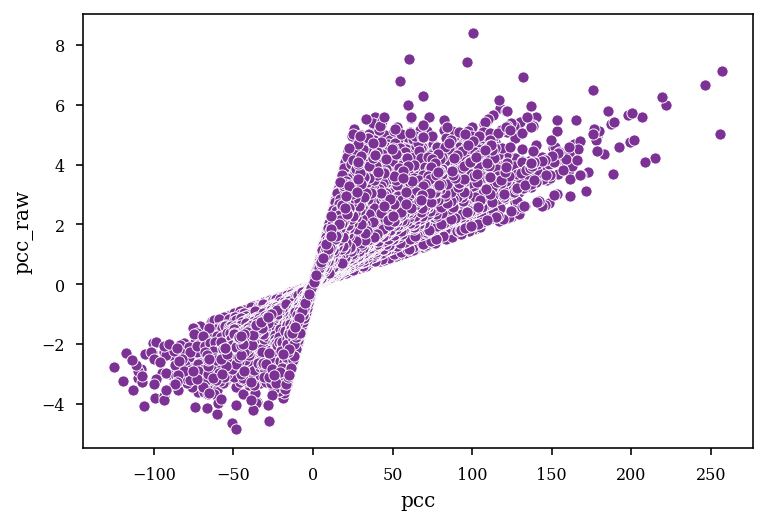

In [247]:
sns.scatterplot(data=results_df,x="pcc",y="pcc_raw")

## add pre task post to results

In [24]:
results_df["session_structure"] = "unknown"
for basepath in results_df.basepath.unique():
    epoch_df = loading.load_epoch(basepath)
    epoch_df = compress_repeated_epochs.main(epoch_df, epoch_name="sleep")
    epoch_df = epoch_df.reset_index()
    pattern_idx, _ = functions.find_epoch_pattern(
        epoch_df.environment, ["sleep", "linear", "sleep"]
    )

    if pattern_idx is None:
        continue

    results_df.loc[
        (results_df.basepath == basepath)
        & (results_df.epoch_n == epoch_df.loc[np.where(pattern_idx)[0]].index[0]),
        "session_structure",
    ] = "pre"
    results_df.loc[
        (results_df.basepath == basepath)
        & (results_df.epoch_n == epoch_df.loc[np.where(pattern_idx)[0]].index[1]),
        "session_structure",
    ] = "task"

    results_df.loc[
        (results_df.basepath == basepath)
        & (results_df.epoch_n == epoch_df.loc[np.where(pattern_idx)[0]].index[2]),
        "session_structure",
    ] = "post"

## plot pcc for pre task post and unknown

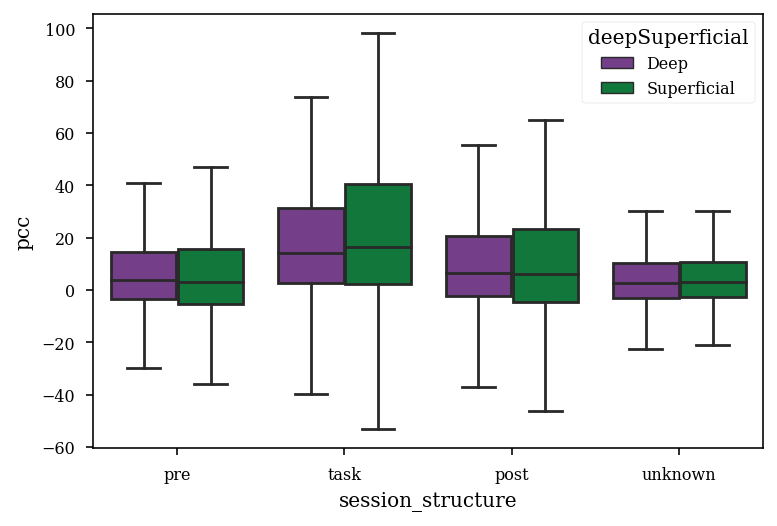

<AxesSubplot:xlabel='session_structure', ylabel='pcc_raw'>

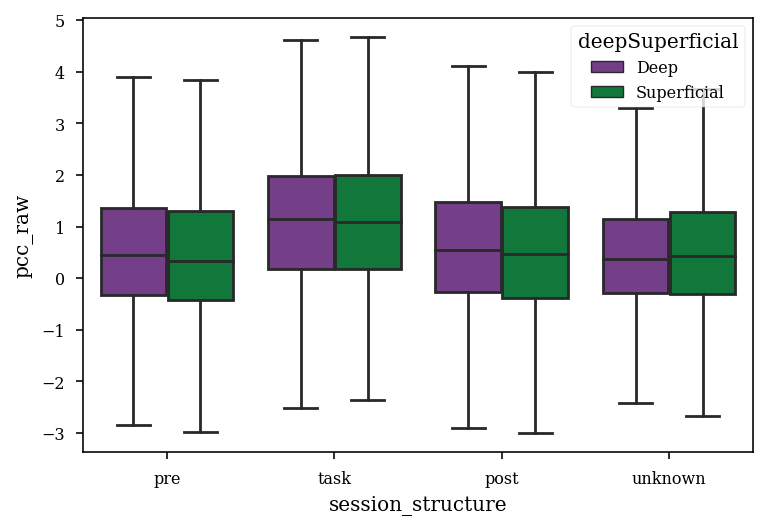

In [250]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    data=results_df.query("deepSuperficial.str.contains('Deep|Superficial') & animal_id != 'HMC2' & n_replays>40"),
    y="pcc",
    x="session_structure",
    order=["pre","task","post","unknown"],
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys()
)
plt.show()

sns.boxplot(
    data=results_df.query("deepSuperficial.str.contains('Deep|Superficial')"),
    y="pcc_raw",
    x="session_structure",
    order=["pre","task","post","unknown"],
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys()
)

# sns.stripplot(
#     data=results_df.query("deepSuperficial.str.contains('Deep|Superficial')"),
#     y="pcc",
#     x="session_structure",
#     dodge=True,
#     hue="deepSuperficial",
# )

## plot pre normalized pcc

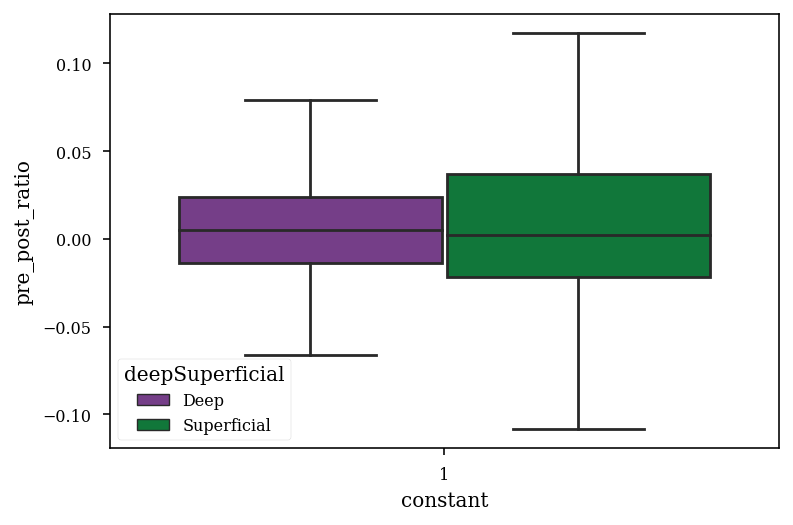

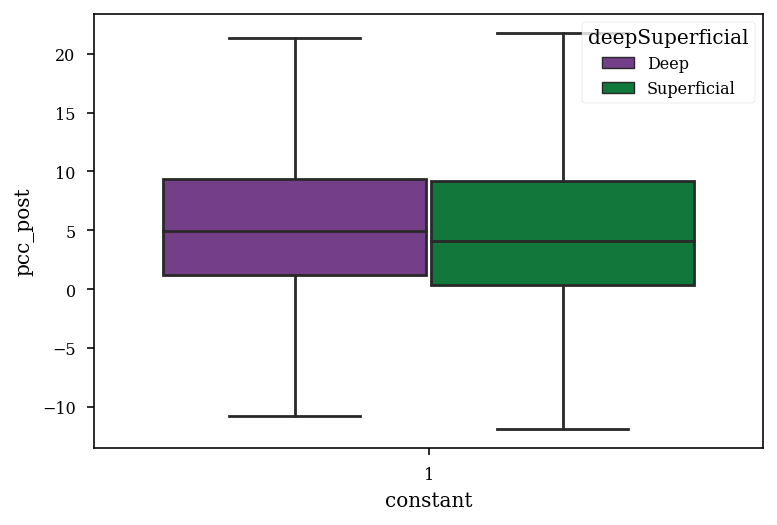

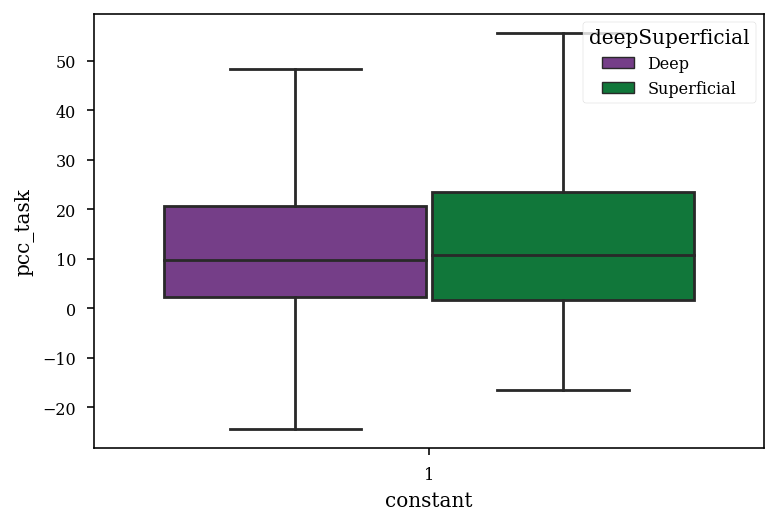

In [216]:
results_df_pivot = pd.pivot_table(
    results_df.query("session_structure != 'unknown' & not pcc.isnull()"),
    values=["pcc"],
    index=["basepath", "UID", "deepSuperficial", "n_replays", "animal_id"],
    columns=["session_structure"],
    aggfunc=np.median,
).reset_index()

results_df_pivot["pre_post_ratio"] = (
    (results_df_pivot["pcc"].post + 100) - (results_df_pivot["pcc"].pre + 100)
) / ((results_df_pivot["pcc"].post + 100) + (results_df_pivot["pcc"].pre + 100))

results_df_pivot["constant"] = 1
results_df_pivot["pcc_post"] = results_df_pivot["pcc"].post.values
results_df_pivot["pcc_task"] = results_df_pivot["pcc"].task.values

sns.boxplot(
    data=results_df_pivot[results_df_pivot.animal_id != "HMC2"],
    y="pre_post_ratio",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
plt.show()

sns.boxplot(
    data=results_df_pivot,
    y="pcc_post",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
# sns.stripplot(
#     data=results_df_pivot[results_df_pivot.animal_id != "HMC2"],
#     y="pcc_post",
#     x="constant",
#     dodge=True,
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     color="k"
# )
plt.show()

sns.boxplot(
    data=results_df_pivot,
    y="pcc_task",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
plt.show()
# results_df_pivot


### normalize post sleep start times 

<AxesSubplot:>

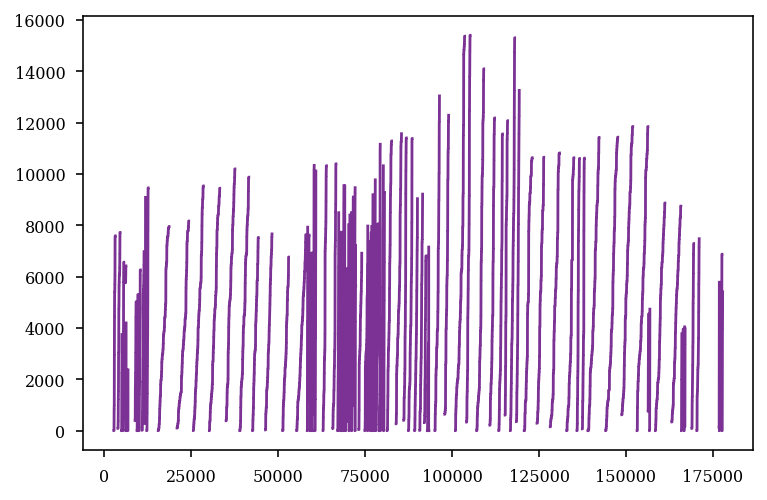

In [202]:
results_df["start_norm"] = np.nan
for basepath in results_df.basepath.unique():

    start = results_df.query("basepath == @basepath & session_structure=='post'").start.values
    if len(start) == 0:
        continue
    results_df.loc[(results_df.basepath==basepath) & (results_df.session_structure=='post'),"start_norm"] = start-start.min()

results_df.start_norm.plot()

## plot pcc 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_Deep vs. 1_Superficial: Mann-Whitney-Wilcoxon test two-sided, P_val:2.263e-02 U_stat=9.420e+05


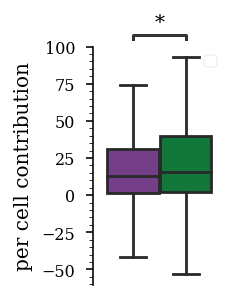

In [251]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

results_df["constant"] = 1
query = "session_structure.str.contains('task') & deepSuperficial.str.contains('Deep|Superficial')"
sns.boxplot(
    data=results_df.query(query),
    y="pcc",
    x="constant",
    showfliers=False,
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
# sns.stripplot(data=results_df.query("environment=='sleep'"),y="pcc",x="deepSuperficial",color="k")


plt.ylabel("per cell contribution")
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.set_xlabel("")
ax.legend("")
box_pairs = [
    ((1, "Deep"), (1, "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results_df.query(query),
    x="constant",
    y="pcc",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

plt.savefig(
    os.path.join(fig_save_path, "per_cell_replay_contribution.svg"),
    dpi=300,
    bbox_inches="tight",
)

plt.show()

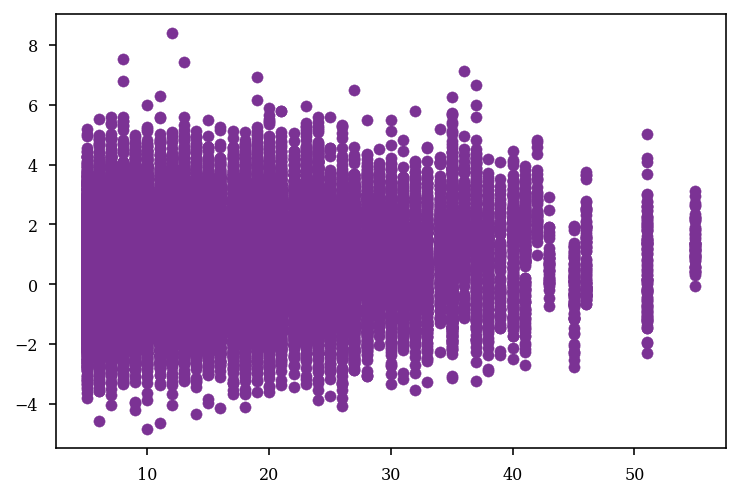

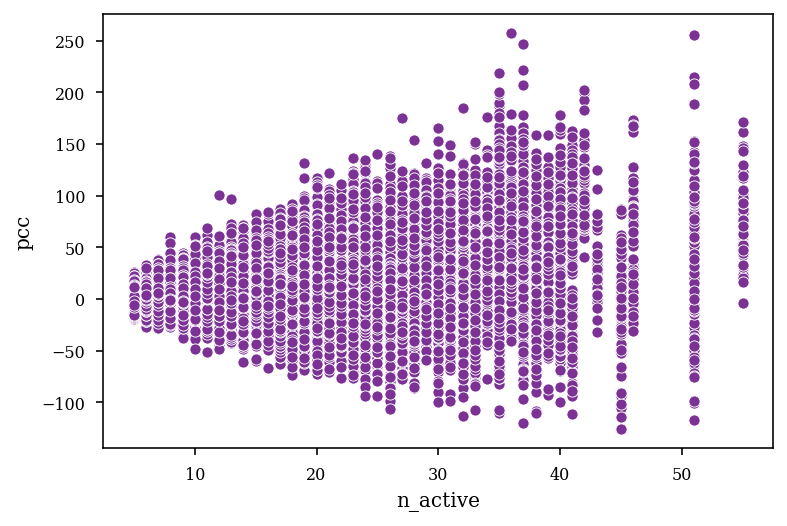

In [245]:
plt.scatter(results_df.n_active, results_df.pcc / results_df.n_active)
plt.show()
sns.scatterplot(data=results_df,x="n_active",y="pcc")
plt.show()


<AxesSubplot:xlabel='pcc', ylabel='Density'>

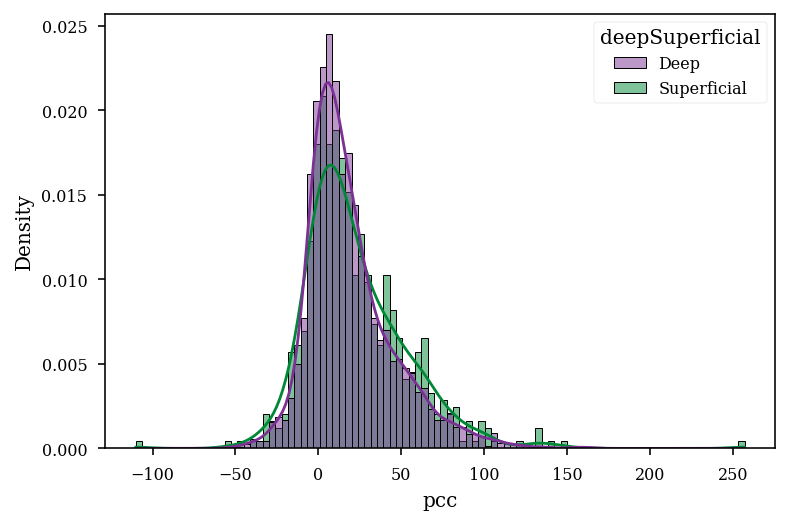

In [237]:
sns.histplot(
    results_df.query("session_structure.str.contains('task') & deepSuperficial.str.contains('Deep|Superficial')"),
    x="pcc", hue="deepSuperficial",
    hue_order=group_colors.keys(),
    # multiple="stack",
    # edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    kde=True,
    stat="density",
    common_norm=False
)

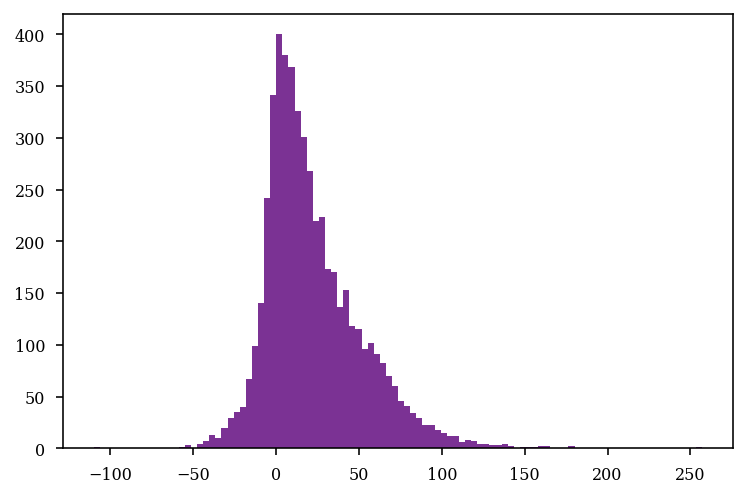

In [224]:
plt.hist(results_df.query("session_structure.str.contains('task')").pcc,100)
plt.show()

In [220]:
results_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\per_cell_contribution.csv")

## Testing below

In [8]:
# locate saved replay file and load it
save_file = os.path.join(
    replay_save_path, basepath.replace(os.sep, "_").replace(":", "_") + ".pkl"
)

with open(save_file, "rb") as f:
    results = pickle.load(f)

In [13]:
tuningcurve = results["outbound_epochs"]["tc"]
tuningcurve

<TuningCurve1D at 0x284e3997a90> with shape (93, 103)

In [40]:
import random

tuningcurve_new = copy.deepcopy(tuningcurve)

shuff_idx = random.sample(range(tuningcurve_new.ratemap.shape[1]),tuningcurve_new.ratemap.shape[0])
x = [np.roll(tc,shuff_val) for tc, shuff_val in zip(tuningcurve_new.ratemap,shuff_idx)]
x = np.array(x)

<AxesSubplot:>

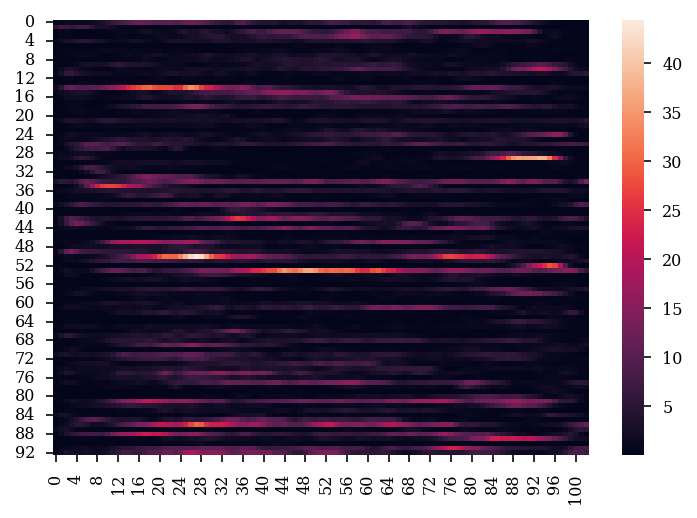

In [26]:
sns.heatmap(tuningcurve_new.ratemap)

In [49]:
n_active = [bst_.n_active for bst_ in bst]
    

In [52]:
np.array(n_active).shape

(7024,)

In [47]:
bst = results["outbound_epochs"]["bst_placecells"]
bst.n_active_per_bin.shape

(34925,)

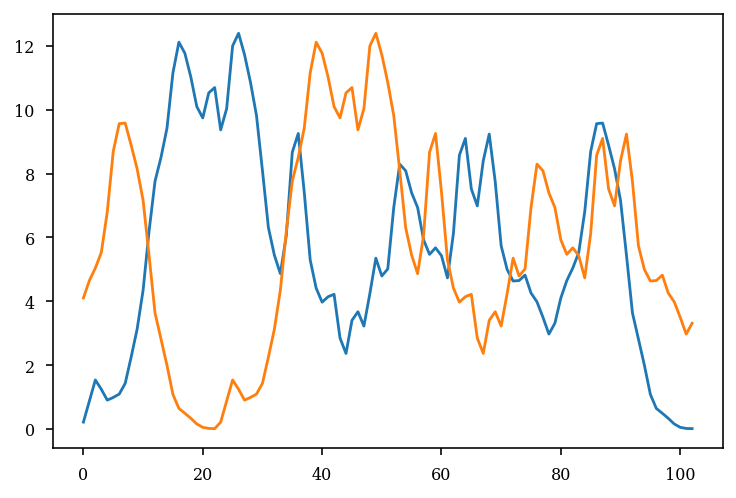

In [41]:
plt.plot(tuningcurve_new.ratemap[0,:])

plt.plot(x[0,:])

<AxesSubplot:>

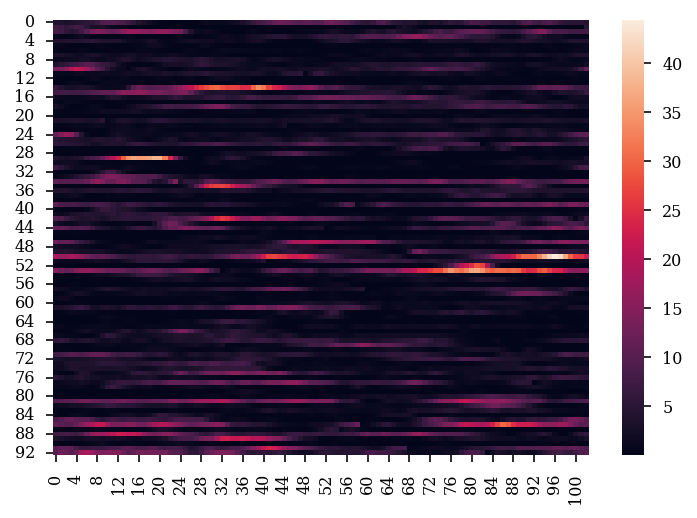

In [31]:
sns.heatmap(x)
